In [1]:
import pandas as pd
import numpy as np

In [ ]:
! mkdir data model submit

# Load Data and Overview

In [2]:
df = pd.read_csv('train.csv').set_index('txkey')
df.shape

(1521787, 22)

In [3]:
y_train = df['fraud_ind']
del df['fraud_ind']

In [4]:
df_test = pd.read_csv('test.csv').set_index('txkey')
df_test.shape

(421665, 21)

In [5]:
df = pd.concat((df, df_test), 0)
df.shape

(1943452, 21)

In [6]:
df.keys()

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'locdt', 'loctm',
       'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd'],
      dtype='object')

In [7]:
# 欄位類別判定
col_names_cont = [] # 數值型資料
col_names_disc = [] # 類別型資料
col_has_na = [] # 待補NA資料
for c in df.keys():
    uni = df[c].unique()
    n_na = pd.isna(df[c]).sum() # NA 數量
    if n_na > 0:
        col_has_na.append(c)       
    if len(uni) < 200 :
        print(f"{c}: uni={uni}")
        col_names_disc.append(c)
    else:
        info = [ df[c].max(), df[c].min(), df[c].mean(), df[c].std()]
        info = [ x.round(2) for x in info ]
        offset = 1 if n_na else 0
        diversity = (len(uni)-offset)/(len(df)-n_na)
        print(f"{c}: dtype={df[c].dtype}, n_na={n_na}")
        print("       max={}, min={}, mean={}, std={}, diversity={:.2f}%".format(*info, diversity*100 ) )
        if diversity == 1.0:
            print(f"       Delete col [{c}] due to diversity is 100% ")
        else:
            col_names_cont.append(c)

acqic: dtype=int64, n_na=0
       max=6884, min=0, mean=6004.54, std=1505.74, diversity=0.35%
bacno: dtype=int64, n_na=0
       max=163886, min=0, mean=82087.41, std=47323.48, diversity=8.40%
cano: dtype=int64, n_na=0
       max=213575, min=0, mean=109045.28, std=61103.56, diversity=10.93%
conam: dtype=float64, n_na=0
       max=7208.77, min=0.0, mean=651.62, std=403.22, diversity=4.44%
contp: uni=[5 3 6 2 4 0 1]
csmcu: uni=[ 0 62 74 61 13 67 60 26 49 10 71 56 20 38 22  4 47 54 75 32 66 29 28 14
 50 30 31 45 24 40 35 59  3 48 63 52 41 23 17 16 73 51 53 44 18 12 15  5
 70 21 39 27 42 11 72  6 25  7 43  2 19 37  1 64 57 36 68 55  9 46 34 69
  8 33 65 58]
ecfg: uni=['N' 'Y']
etymd: uni=[ 0  2  5  4  8  1  9  6  3  7 10]
flbmk: uni=['N' 'Y' nan]
flg_3dsmk: uni=['N' 'Y' nan]
hcefg: uni=[5 0 3 1 2 7 8 9 6 4]
insfg: uni=['N' 'Y']
iterm: uni=[0 1 2 8 3 4 7 6 5]
locdt: uni=[ 33   9   6   5   7  10   8  11  13  14  22  21  25  24  15  12  19  28
  18  17  16  23  31  26   2  30   4  20  27  29  

- 看起來數值型資料都沒有缺失值(n_na==0)

In [8]:
col_has_na

['flbmk', 'flg_3dsmk']

In [9]:
# 處理缺失值
df = df.fillna("NA")

# Data Preprocessing

## 數值型

In [10]:
df_cont = df[col_names_cont].copy()
df_cont.head()

,acqic,bacno,cano,conam,loctm,mcc,mchno,scity
txkey,,,,,,,,
516056,6881,113261,38038,513.80,172652.0,457,59333,0
4376,0,134508,45725,465.62,105114.0,451,0,5817
483434,6881,15408,188328,513.80,152458.0,457,59333,0
1407164,6716,157159,29967,1016.11,172946.0,247,50436,3281
1051004,5975,105985,81305,713.66,182129.0,263,93775,5817


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cont = scaler.fit_transform(df_cont)
X_cont.shape, type(X_cont)

((1943452, 8), numpy.ndarray)

In [12]:
df_cont = pd.DataFrame(data=X_cont, index=df.index, columns=col_names_cont)
df_cont.head()

,acqic,bacno,cano,conam,loctm,mcc,mchno,scity
txkey,,,,,,,,
516056,0.582079,0.658734,-1.162081,-0.341794,0.509681,2.028863,0.111604,-2.398364
4376,-3.987783,1.107708,-1.036278,-0.461282,-0.782179,1.952344,-1.812952,0.536031
483434,0.582079,-1.409013,1.297514,-0.341794,0.123412,2.028863,0.111604,-2.398364
1407164,0.472498,1.586350,-1.294169,0.903959,0.515305,-0.649316,-0.176983,-0.743258
1051004,-0.019621,0.504984,-0.453988,0.153869,0.690956,-0.445264,1.228783,0.536031


## 類別型

In [13]:
df_disc = df[col_names_disc].copy()
df_disc.head()

,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,ovrlt,stocn,stscd
txkey,,,,,,,,,,,,,
516056,5,0,N,0,N,N,5,N,0,33,N,102,0
4376,5,0,N,2,N,N,0,N,0,9,N,102,0
483434,5,0,N,0,N,N,5,N,0,6,N,102,0
1407164,5,62,N,5,N,N,5,N,0,5,N,102,0
1051004,5,62,N,4,N,N,5,N,0,6,N,102,0


In [14]:
df_disc.shape

(1943452, 13)

In [15]:
from sklearn.preprocessing import LabelEncoder
les = {}
for c in col_names_disc:
    le = LabelEncoder()
    df_disc.loc[:,c] = le.fit_transform(df_disc.loc[:,c])
    les.update({c:le})
df_disc.head()

,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,ovrlt,stocn,stscd
txkey,,,,,,,,,,,,,
516056,5,0,0,0,0,0,5,0,0,32,0,102,0
4376,5,0,0,2,0,0,0,0,0,8,0,102,0
483434,5,0,0,0,0,0,5,0,0,5,0,102,0
1407164,5,62,0,5,0,0,5,0,0,4,0,102,0
1051004,5,62,0,4,0,0,5,0,0,5,0,102,0


In [16]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
X_disc = ohe.fit_transform(df_disc)
cut_point = ohe.feature_indices_
print("feature cut point: ", cut_point)
X_disc.shape, type(X_disc)

feature cut point:  [  0   7  83  85  96  99 102 112 114 123 243 245 354 359]


((1943452, 359), numpy.ndarray)

In [17]:
new_col_names_disc = []
for c in col_names_disc: 
    le = les[c]
    new_col_names_disc += [ c+'_'+str(cl) for cl in le.classes_ ]
assert len(new_col_names_disc) == X_disc.shape[1]

In [18]:
df_disc = pd.DataFrame(data=X_disc, index=df.index, columns=new_col_names_disc)
df_disc.head()

,contp_0,contp_1,contp_2,contp_3,contp_4,contp_5,contp_6,csmcu_0,csmcu_1,csmcu_2,...,stocn_104,stocn_105,stocn_106,stocn_107,stocn_108,stscd_0,stscd_1,stscd_2,stscd_3,stscd_4
txkey,,,,,,,,,,,,,,,,,,,,,
516056,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4376,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
483434,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1407164,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1051004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
df_disc.keys()

Index(['contp_0', 'contp_1', 'contp_2', 'contp_3', 'contp_4', 'contp_5',
       'contp_6', 'csmcu_0', 'csmcu_1', 'csmcu_2',
       ...
       'stocn_104', 'stocn_105', 'stocn_106', 'stocn_107', 'stocn_108',
       'stscd_0', 'stscd_1', 'stscd_2', 'stscd_3', 'stscd_4'],
      dtype='object', length=359)

In [20]:
df = pd.concat((df_cont, df_disc), 1)
df.shape

(1943452, 367)

# Data Tree Encoding

# Data Dimension Reduction

In [21]:
%%time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
X_red_pca = pca.fit_transform(df)
X_red_pca.shape

CPU times: user 50.4 s, sys: 38.5 s, total: 1min 28s
Wall time: 1min 18s


In [22]:
df_pca = pd.DataFrame(data=X_red_pca, index=df.index, columns=[ "pca_"+str(i) for i in range(X_red_pca.shape[1])])
df = pd.concat((df, df_pca), 1)
df.shape

(1943452, 369)

In [ ]:
df.to_csv('data/data_20190923.csv')

# Data Split & Compare Train/Test

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
n_train = len(y_train)

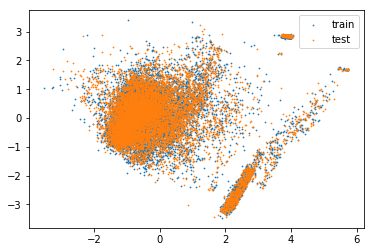

In [26]:
n_sample = 10000
idx_train_sample = np.random.randint(0, n_train, size=n_sample)
idx_test_sample = np.random.randint(n_train, len(df),  size=n_sample)
X_train_red_sample = X_red_pca[idx_train_sample, :] 
X_test_red_sample = X_red_pca[idx_test_sample, :]
plt.scatter( *X_train_red_sample.T , label='train', s=0.5)
plt.scatter( *X_test_red_sample.T  , label='test', s=0.5)
plt.legend()

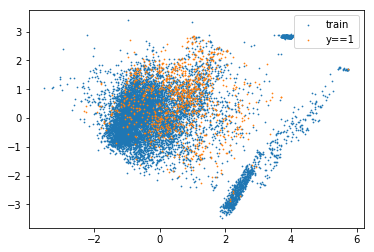

In [27]:
n_sample_y1 = 1000
idx_train_y1 = np.random.choice(np.where(y_train==1)[0], size=n_sample_y1)
X_train_red_y1_sample = X_red_pca[idx_train_y1, :]
plt.scatter( *X_train_red_sample.T , label='train', s=0.5)
plt.scatter( *X_train_red_y1_sample.T , label='y==1', s=0.5)
plt.legend()

In [28]:
X_train, X_test = df.iloc[:n_train, :].values, df.iloc[n_train:, :].values
key_train, key_test = np.array(df.index[:n_train]), np.array(df.index[n_train:])
X_train.shape, X_test.shape, y_train.shape

((1521787, 369), (421665, 369), (1521787,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train_, X_val, y_train_, y_val, key_train_, key_val =  \
train_test_split(X_train, y_train, key_train, test_size=0.3, random_state=42)
X_train_.shape, y_train_.shape, X_val.shape, y_val.shape, key_train_.shape, key_val.shape

In [ ]:
np.save('data/X_train', X_train)
np.save('data/X_test', X_test)
np.save('data/y_train', y_train)
np.save('data/X_train_', X_train_)
np.save('data/X_val', X_val)
np.save('data/y_train_', y_train_)
np.save('data/y_val', y_val)

In [ ]:
np.save('data/X_col_names', np.array(df.columns))

In [ ]:
# txkey
np.save('data/key_train', key_train) 
np.save('data/key_test', key_test) 
np.save('data/key_train_', key_train_) 
np.save('data/key_val', key_val) 